In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#Data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
#Sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocessing
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

## Importing data

In [2]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='C:/Users/admin/Documents/MATERIAL/Coding/Year 2/models/Flower Recognition System/flowers/daisy'
FLOWER_SUNFLOWER_DIR='C:/Users/admin/Documents/MATERIAL/Coding/Year 2/models/Flower Recognition System/flowers/sunflower'
FLOWER_TULIP_DIR='C:/Users/admin/Documents/MATERIAL/Coding/Year 2/models/Flower Recognition System/flowers/tulip'
FLOWER_DANDI_DIR='C:/Users/admin/Documents/MATERIAL/Coding/Year 2/models/Flower Recognition System/flowers/dandelion'
FLOWER_ROSE_DIR='C:/Users/admin/Documents/MATERIAL/Coding/Year 2/models/Flower Recognition System/flowers/rose'

## Creating functions to get validation and training

In [4]:
def assign_label(img,flower_type):
    return flower_type

In [5]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))


make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

  2%|▏         | 16/733 [00:00<00:04, 155.68it/s]

764


  3%|▎         | 25/984 [00:00<00:03, 242.58it/s]

1497


  2%|▏         | 17/1052 [00:00<00:06, 159.87it/s]

2481


  4%|▍         | 31/784 [00:00<00:02, 299.25it/s]

3533


100%|██████████| 784/784 [00:04<00:00, 182.80it/s]

4317


## Visualizing data

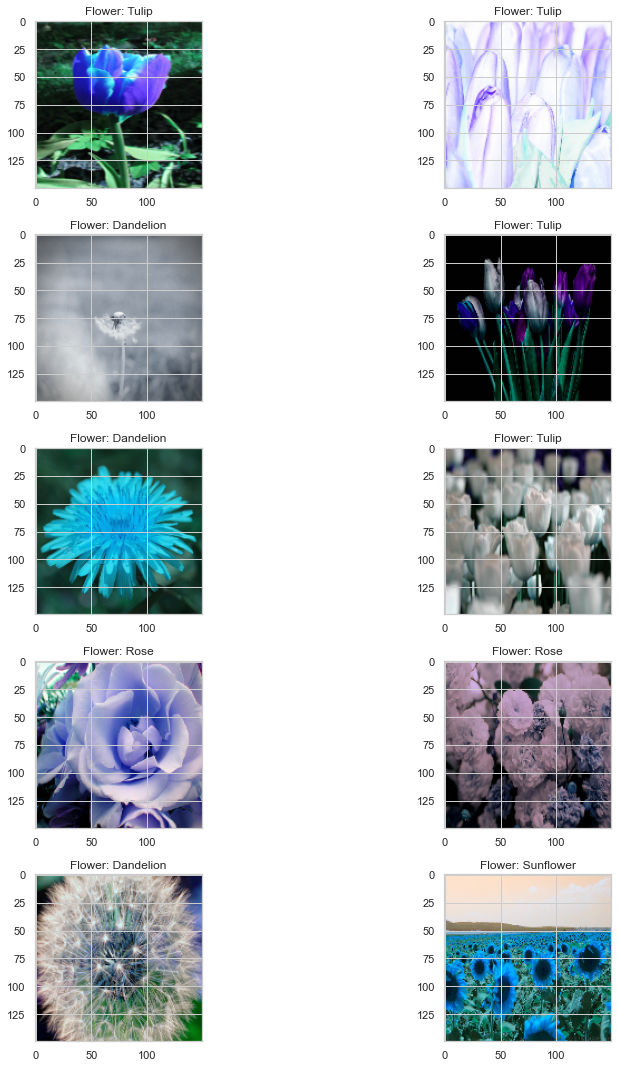

In [6]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

### Label Encoding followed by one hot encoding.

In [7]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

### Splitting into test and train sets.

In [8]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

### Random seeding

In [9]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## Model Creation

### Building the ConvNet Model

In [10]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

### Using a LR Annealer

In [11]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

###  Data Augmentation to prevent Overfitting¶

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### Compiling the model 

In [13]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 96)        8

### Fitting traing set and predictions

In [14]:

History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
25/25 [==============================] - 140s 5s/step - loss: 1.4276 - accuracy: 0.3660 - val_loss: 1.1667 - val_accuracy: 0.4778
Epoch 2/50
25/25 [==============================] - 123s 5s/step - loss: 1.1956 - accuracy: 0.4995 - val_loss: 1.1512 - val_accuracy: 0.5120
Epoch 3/50
25/25 [==============================] - 118s 5s/step - loss: 1.0898 - accuracy: 0.5696 - val_loss: 1.0271 - val_accuracy: 0.5824
Epoch 4/50
25/25 [==============================] - 119s 5s/step - loss: 1.0261 - accuracy: 0.5963 - val_loss: 1.0149 - val_accuracy: 0.5944
Epoch 5/50
25/25 [==============================] - 117s 5s/step - loss: 0.9675 - accuracy: 0.6269 - val_loss: 0.9920 - val_accuracy: 0.6037
Epoch 6/50
25/25 [==============================] - 116s 5s/step - loss: 0.9377 - accuracy: 0.6388 - val_loss: 0.8464 - val_accuracy: 0.6611
Epoch 7/50
25/25 [==============================] - 117s 5s/step - loss: 0.8745 - accuracy: 0.6603 - val_loss: 0.9291 - val_accuracy: 0.6472
Epoch 8/50
25

### Evaluating model performance

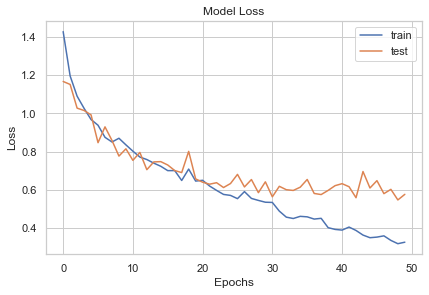

In [15]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

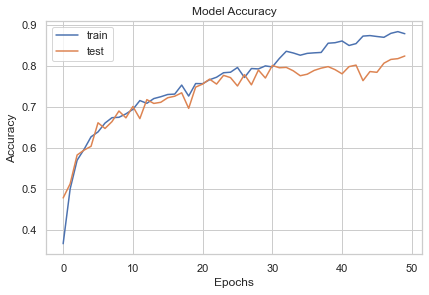

In [17]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## Visualizing Predictions

In [18]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

## Results

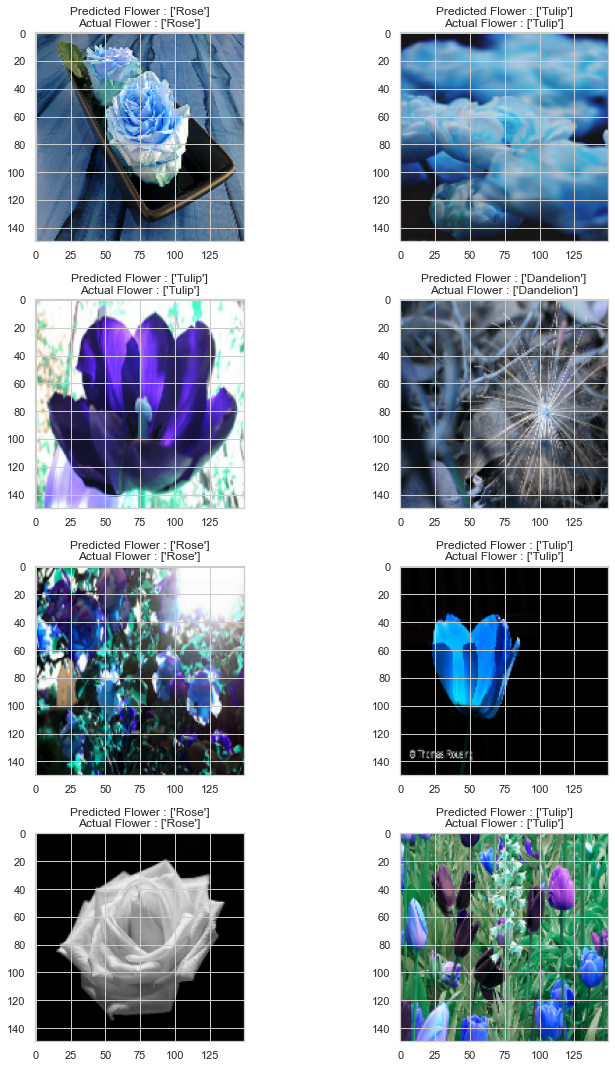

In [22]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[prop_class[count]])])))
        plt.tight_layout()
        count+=1

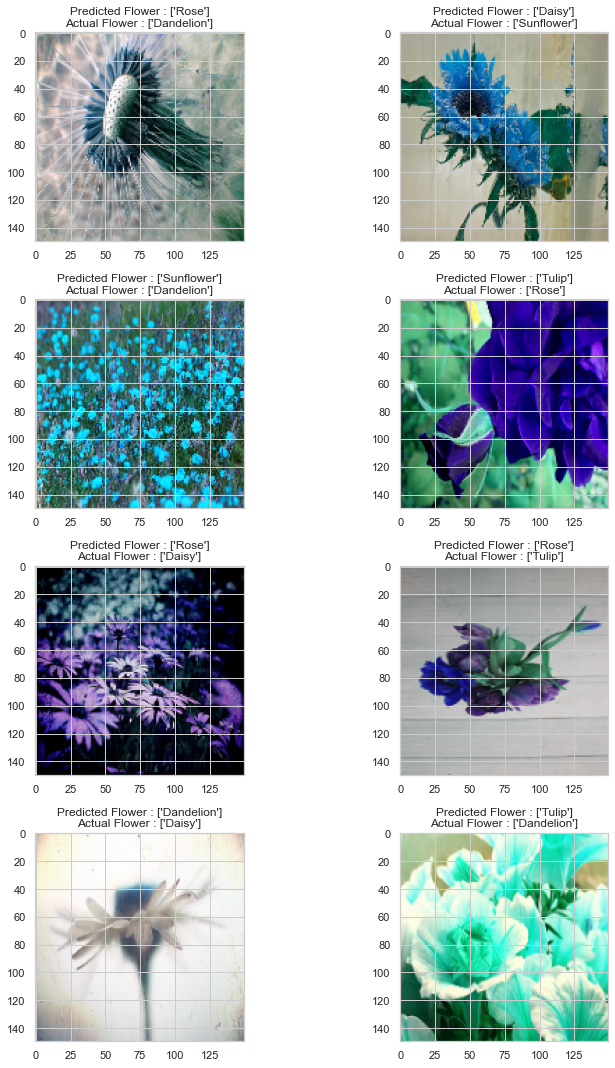

In [24]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[mis_class[count]])])))
        plt.tight_layout()
        count+=1